In [1]:
import sys
import os
sys.path.append("../../src")
sys.path.append("../../data")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from IPython import display
import pylab as pl

from BCA import *
from general_utils import *
from visualization_utils import * 

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'Nonnegative_Antisparse_Copula'

# np.random.seed(250)

In [2]:
image_paths = '../../data/TestImages'
images = []
for im_dir in os.listdir(image_paths):
    try:
        images.append(mpimg.imread(os.path.join(image_paths,im_dir)))
    except:
        pass
images = np.array(images)

In [3]:
small_images = np.zeros((images.shape[0],324* 432* 3))
small_to_large_image_size_ratio = 0.1
for i in range(images.shape[0]):
    small_img = cv2.resize(images[i], # original image
                           (0,0), # set fx and fy, not the final size
                           fx=small_to_large_image_size_ratio, 
                           fy=small_to_large_image_size_ratio, 
                           interpolation=cv2.INTER_NEAREST)
    if small_img.shape[0] == 302:
        small_img = cv2.resize(small_img, (0,0), fx = 432/403, fy = 324/302)
    print(small_img.shape)
    small_images[i] = small_img.reshape(-1,)/255

small_images.shape

(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)


(14, 419904)

In [4]:
display_matrix(np.corrcoef(small_images))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

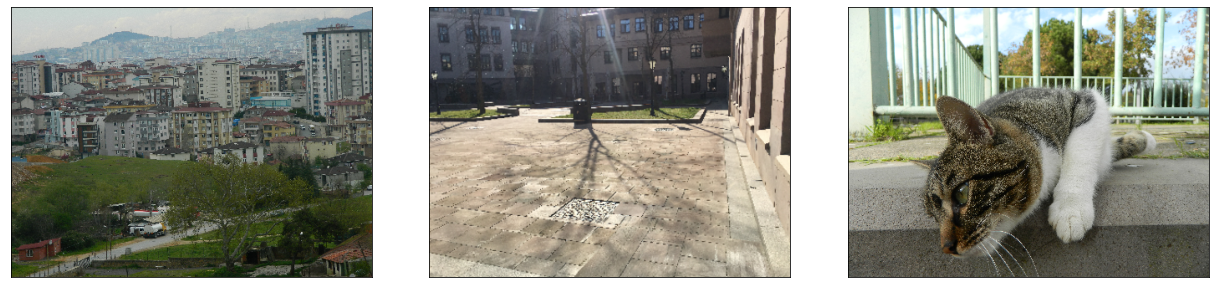

In [5]:
S = small_images[[2,4,3]]
Subplot_RGB_images(S, imsize = [324,432], height = 4, width = 18)
display_matrix(np.corrcoef(S))
# plt.savefig('Original_Images.pdf', format = 'pdf', dpi = 1500)

In [6]:
np.random.seed(50)
NumberofMixtures = 5
NumberofSources = 3
# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
A = np.random.uniform(-1,1,(NumberofMixtures,NumberofSources))
X = np.dot(A,S)

SNR = 40
X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

X_ = ZeroOneNormalizeColumns(X.T).T # For image plotting of mixtures

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 40.00195279179997


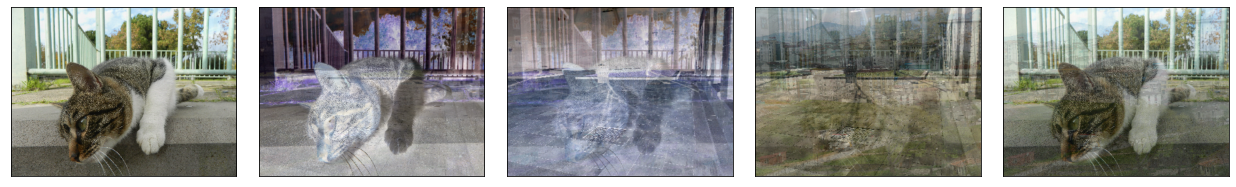

In [7]:
Subplot_RGB_images(X_, imsize = [324,432], height = 3, width = 18)
# plt.savefig('Mixture_Images.pdf', format = 'pdf', dpi = 1500)

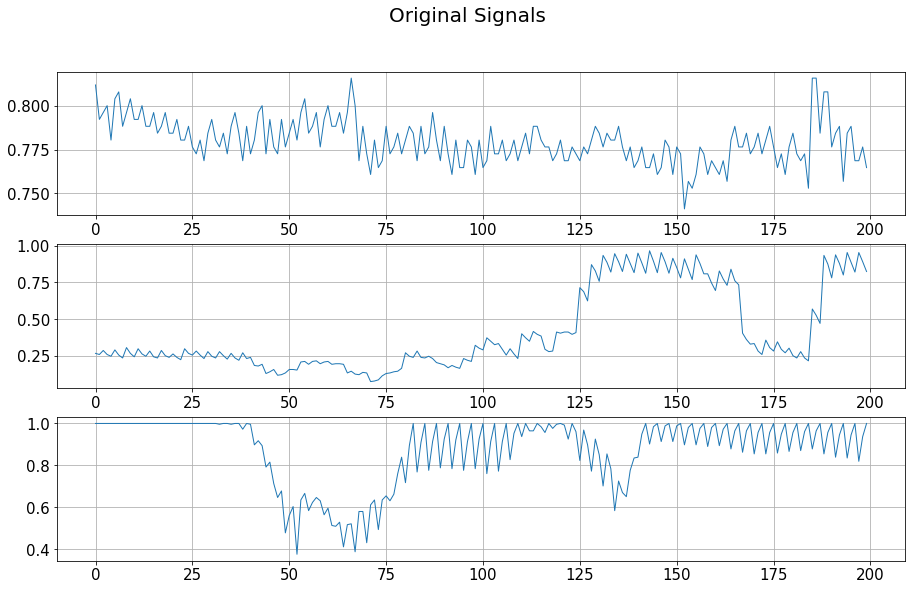

In [8]:
subplot_1D_signals(S[:,1000:1200], title = 'Original Signals', figsize = (15.2,9), colorcode = None)

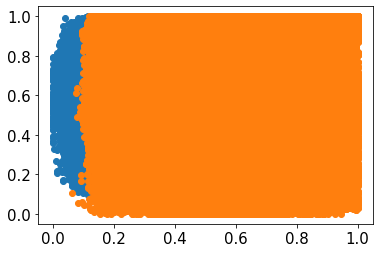

In [9]:
plt.scatter(S[0,:], S[1,:])
plt.scatter(S[1,:], S[2,:])

In [10]:
lambda_ = 0.999
mu_F = 0.05
beta = 5
debug_iteration_point = 25000

model = OnlineBCA(s_dim = NumberofSources, x_dim = NumberofMixtures, 
                  lambda_ = lambda_, mu_F = mu_F, beta = beta, 
                  set_ground_truth = True, S = S, A = A)

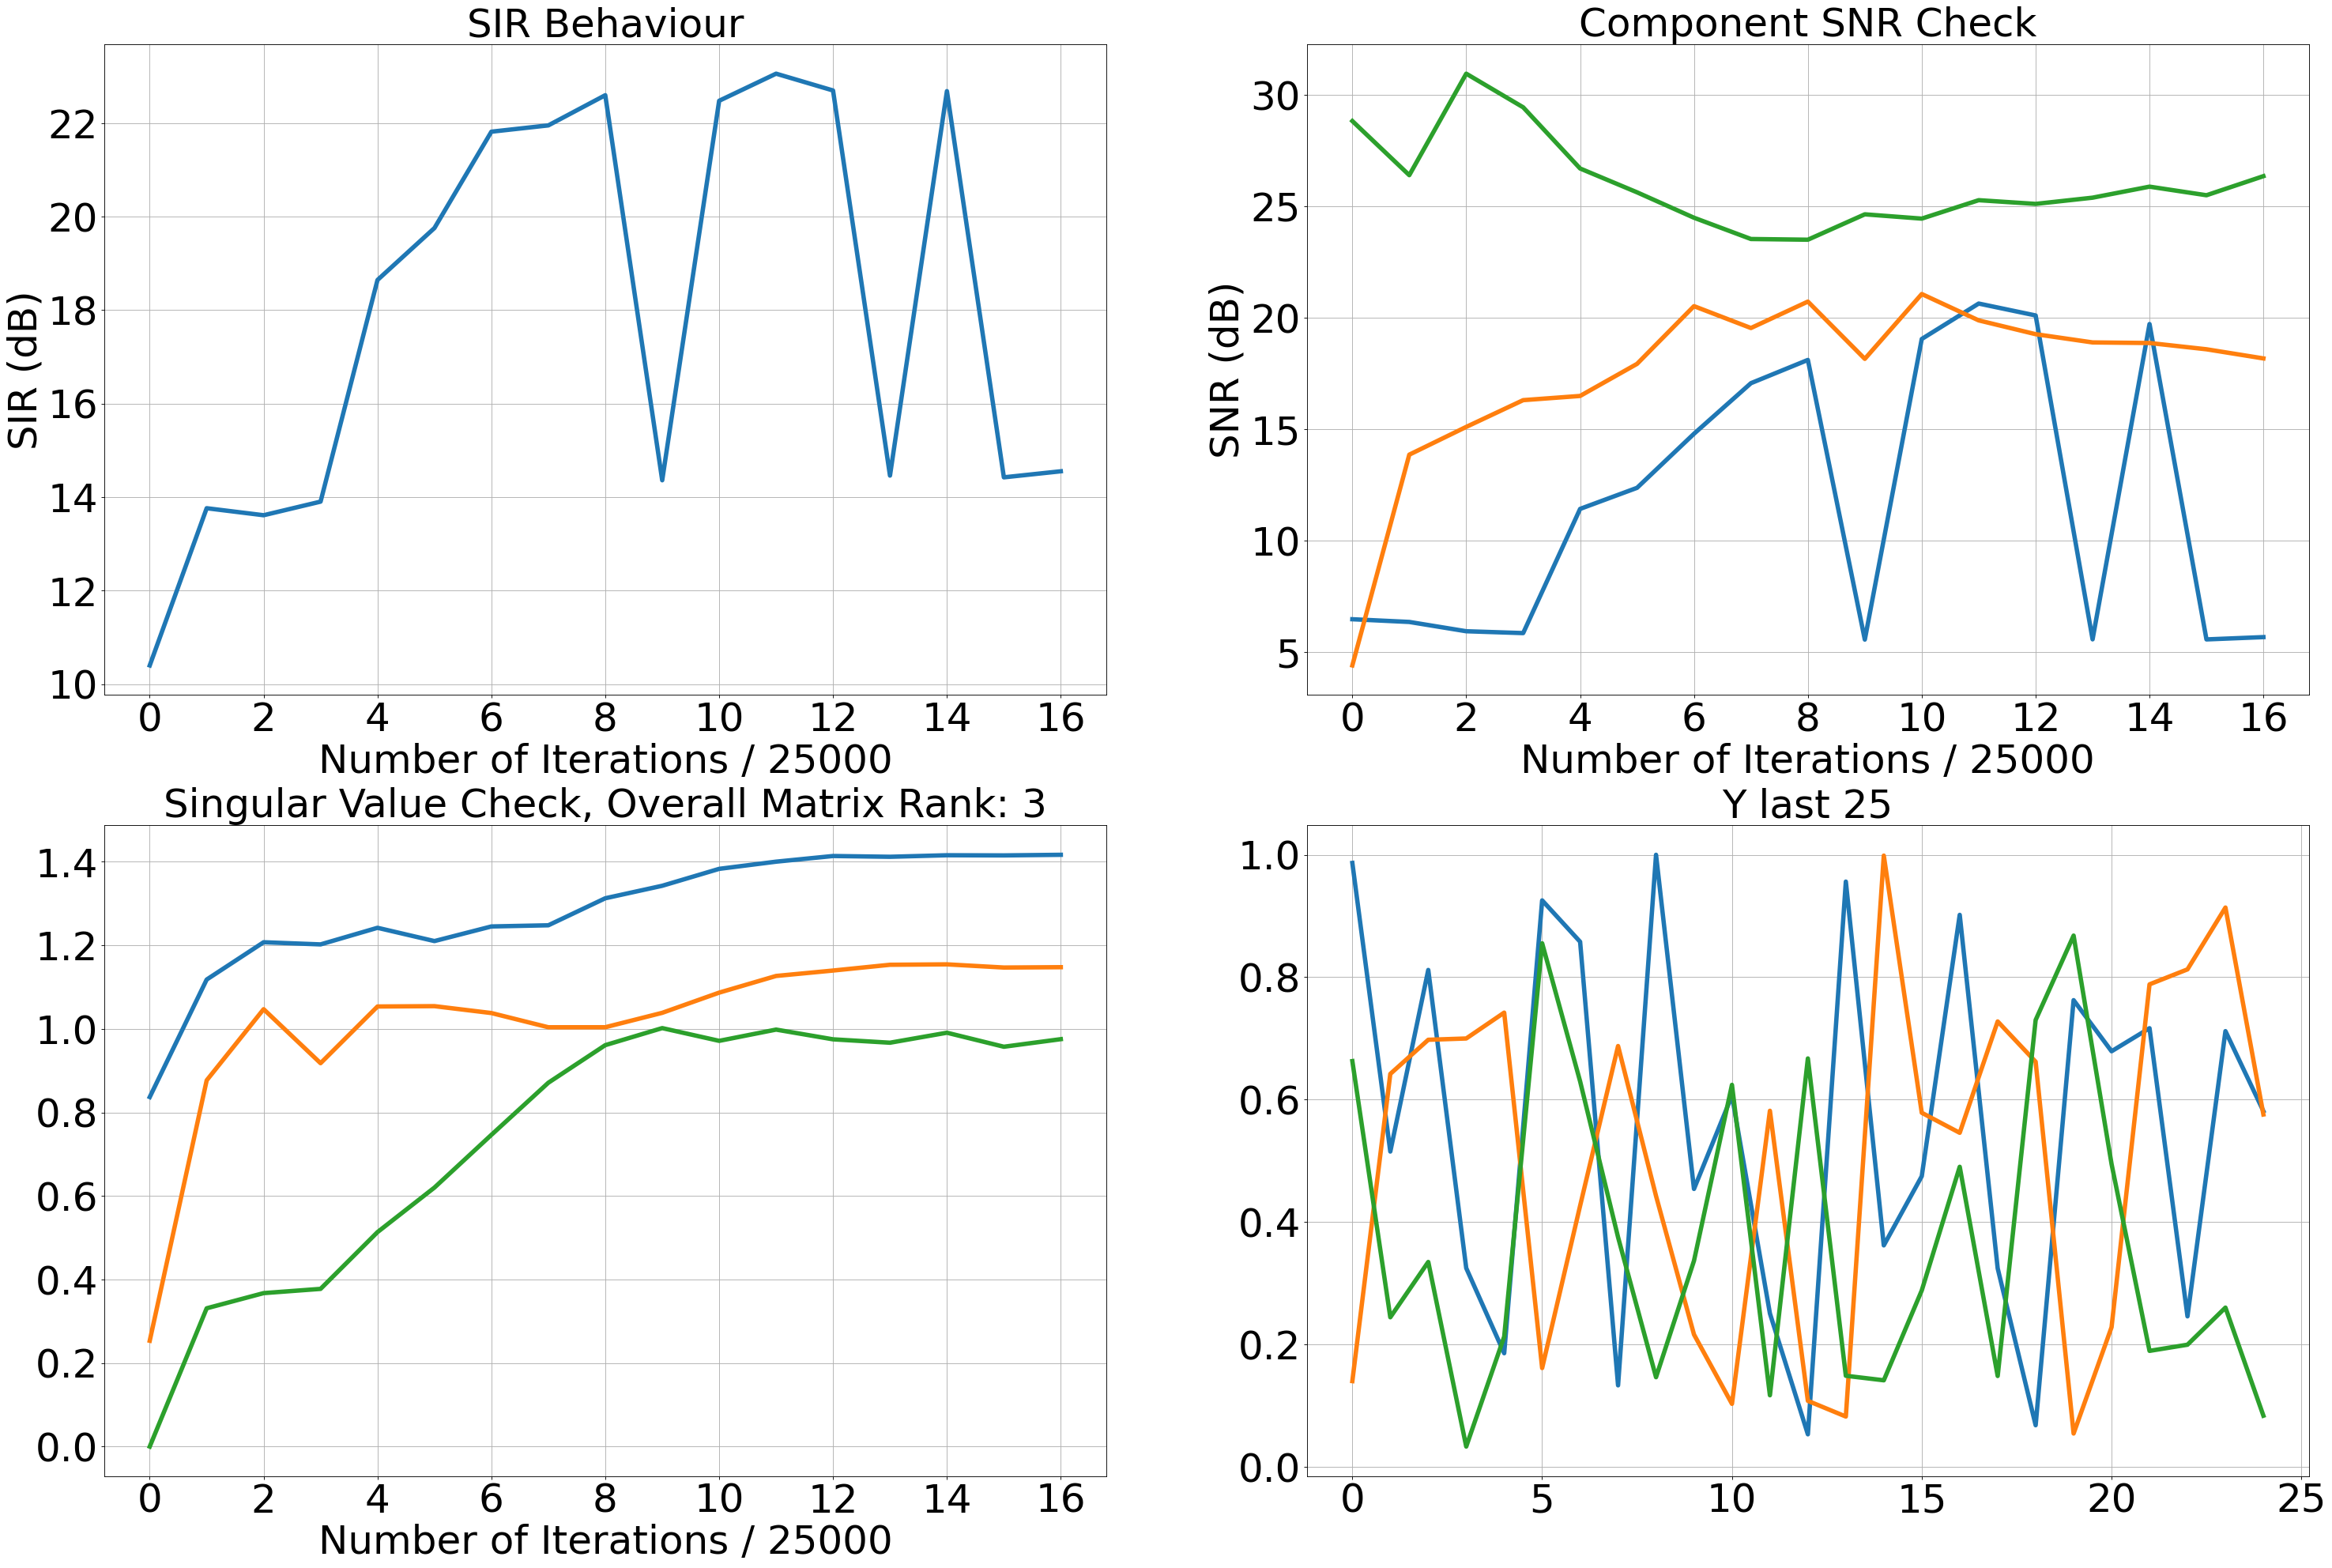

100%|██████████| 419904/419904 [01:16<00:00, 5505.10it/s] 


Algorithm took 76.430815 sec.


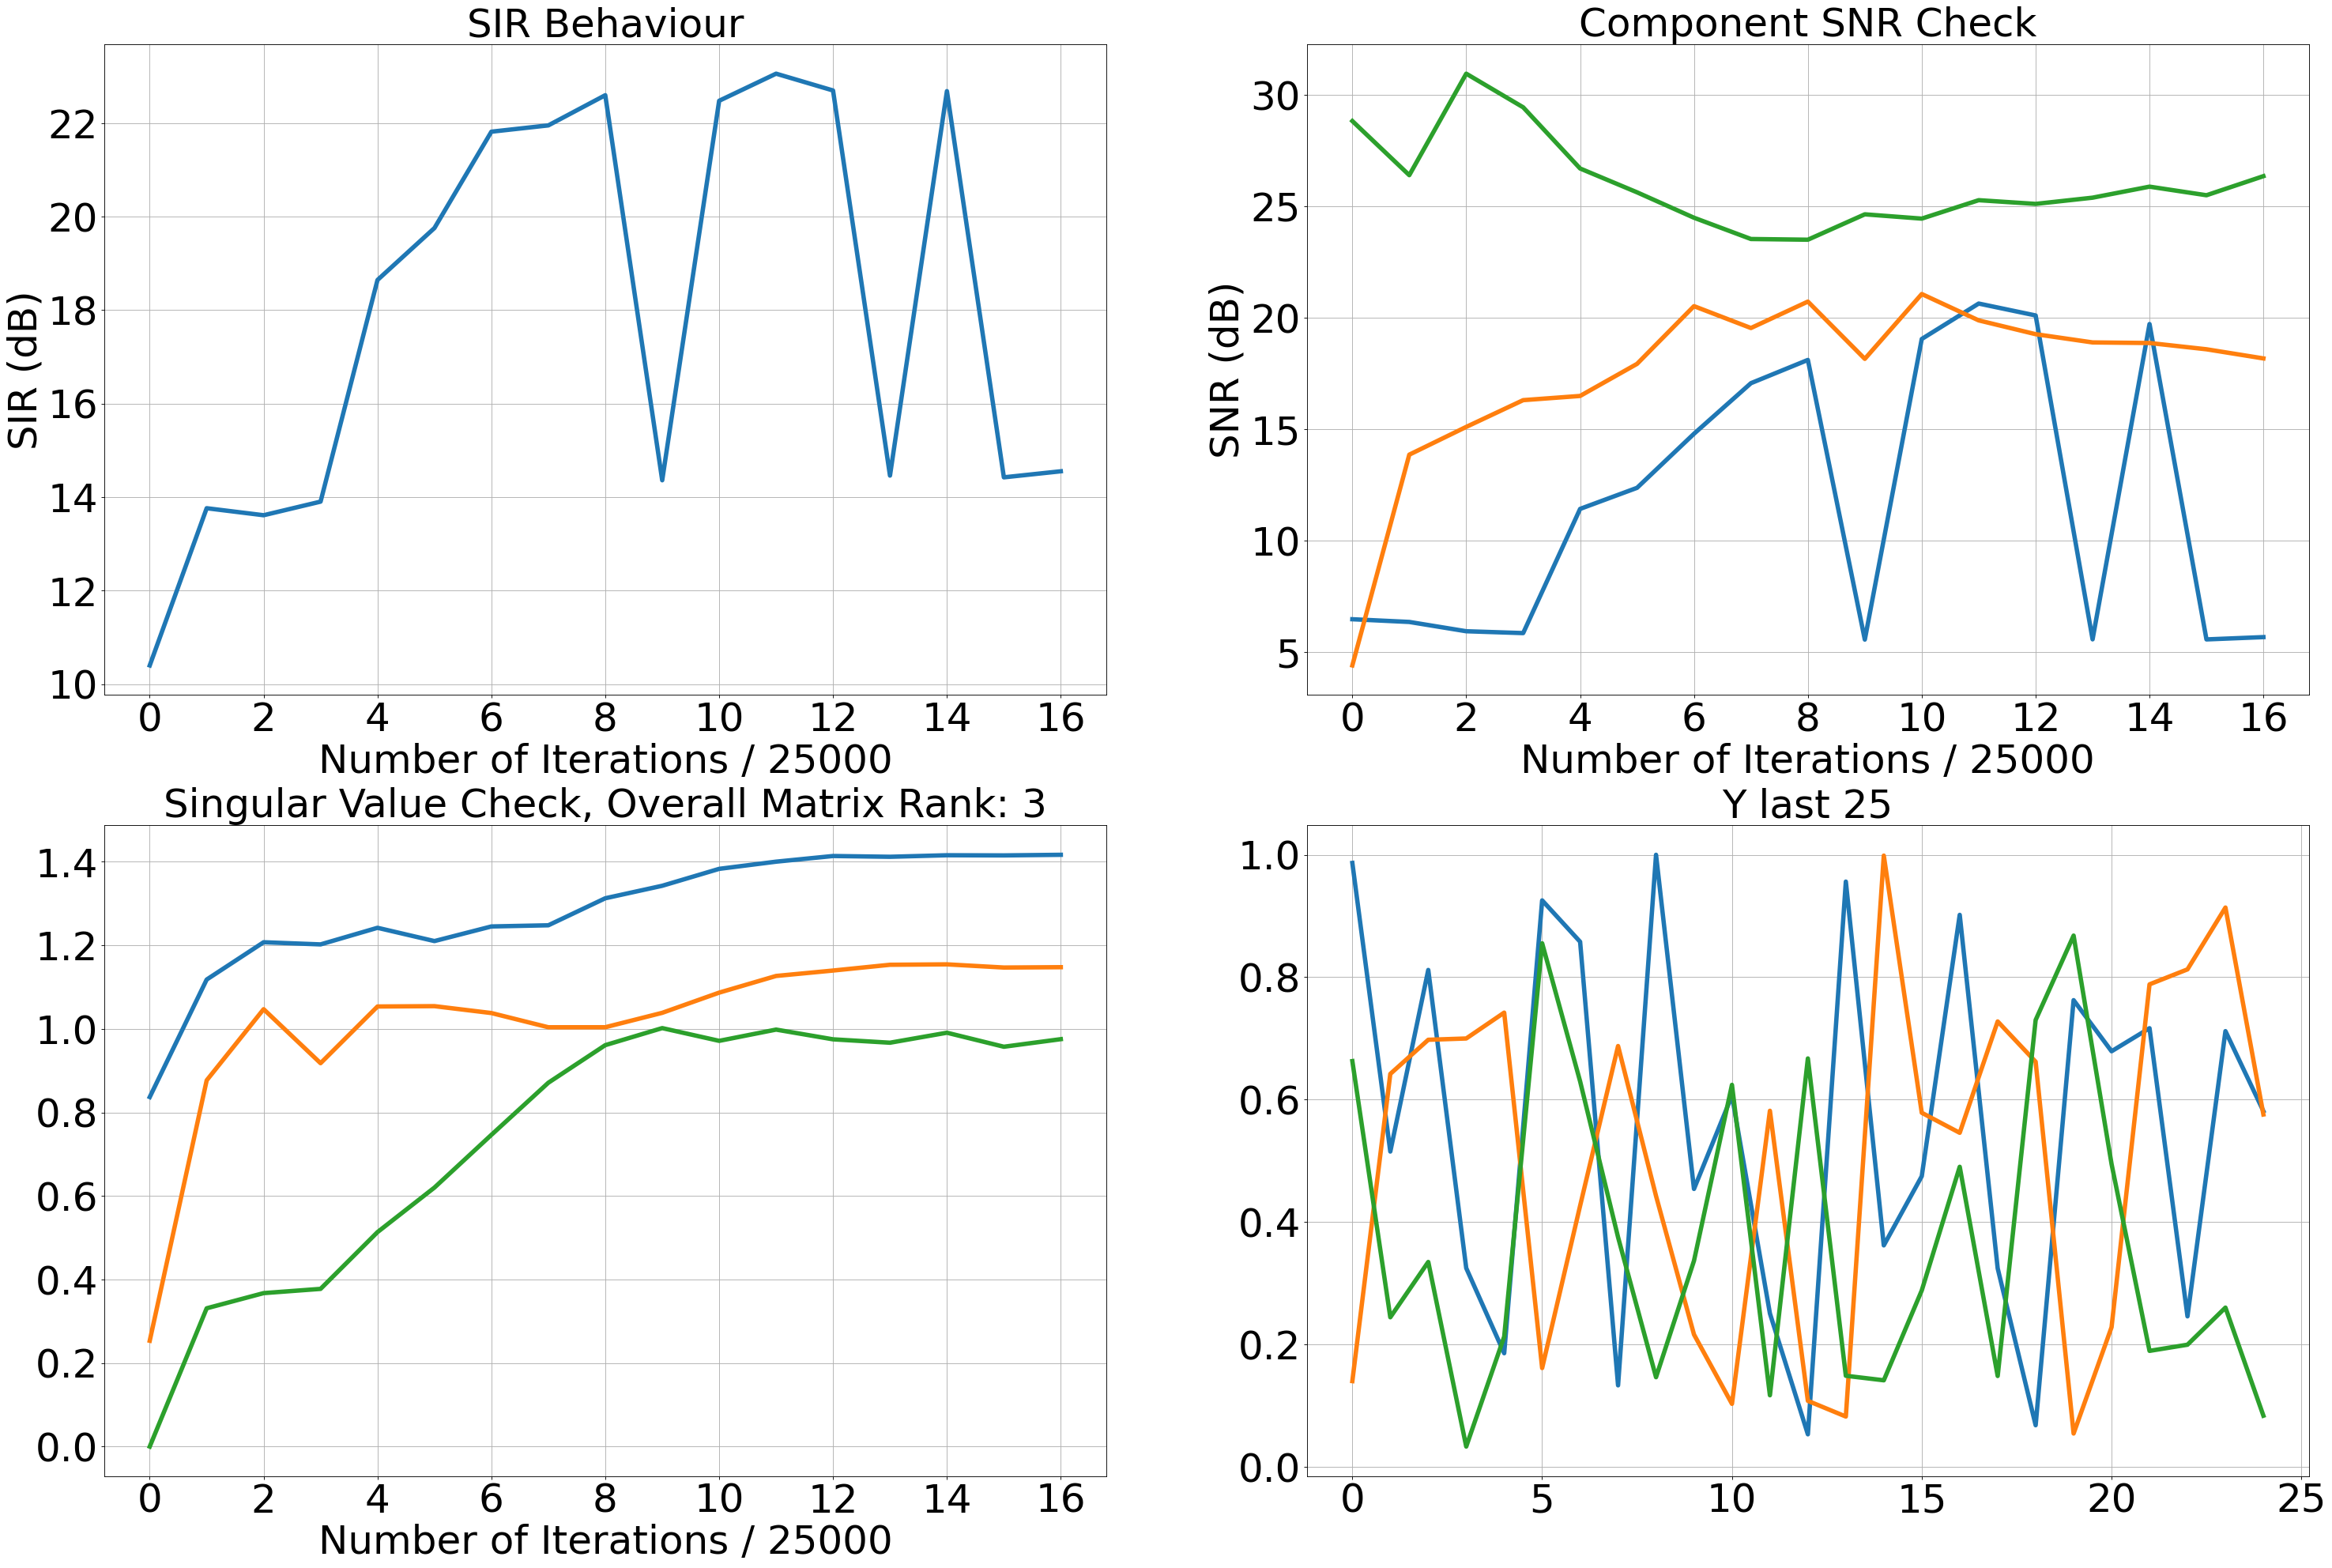

In [11]:
with Timer() as t:
    model.fit_batch_nnantisparse(X, n_epochs = 1, neural_lr_start = 0.5, 
                                 neural_dynamic_iterations = 500, 
                                 shuffle = True, 
                                 debug_iteration_point = debug_iteration_point,
                                 plot_in_jupyter = True)
print('Algorithm took %f sec.' % (t.interval))

In [12]:
Wf = model.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S,Y)
coef_ = ((Y_ * S).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINR = 10*np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [ 5.62811178 16.72393433 26.32797929]

Overall SINR : 23.259357660432688


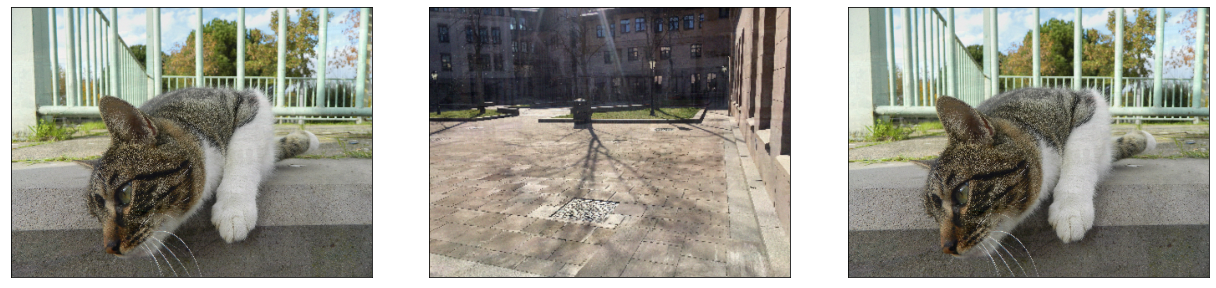

In [13]:
Subplot_RGB_images(ZeroOneNormalizeColumns(Y_.T).T, imsize = [324,432], height = 4, width = 18)
# plt.savefig('WSM_Output.pdf', format = 'pdf', dpi = 1500)

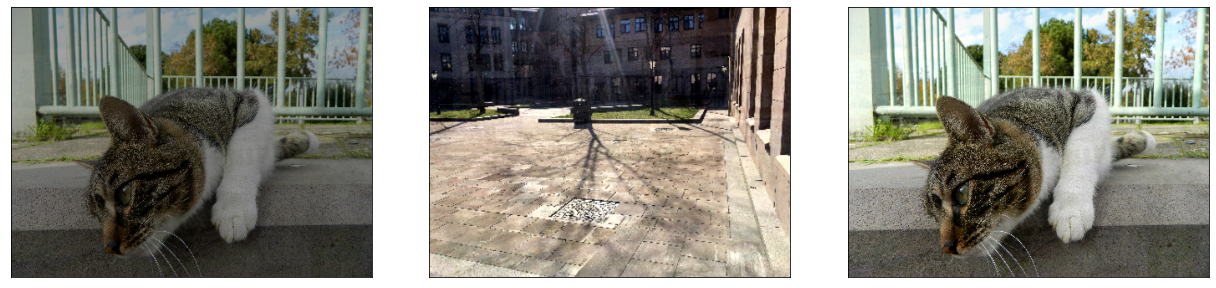

In [14]:
Subplot_RGB_images(np.clip(Y_, 0,1), imsize = [324,432], height = 4, width = 18)